## “유랑지구” 영화 리뷰 텍스트 데이터 마이닝



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import jieba
import matplotlib.pyplot as plt
import jieba.analyse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from snownlp import SnowNLP
import plotly.express as px
from sklearn.metrics import classification_report,confusion_matrix,precision_score
from gensim import corpora, models
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
# 显示cell运行时长
%load_ext klab-autotime

import warnings
warnings.filterwarnings('ignore')

### 1、데이터 전처리

In [2]:
df=pd.read_csv('./data/流浪地球.csv')
df.head()

citys                                            content evaluate labs  \
0  ['北京']            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐   看过   
1  ['北京']  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐   看过   
2  ['北京']  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差   看过   
3  ['北京']  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐   看过   
4      []  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差   看过   

      nams  scores                times                             user_info  \
0     沙雕电影  ['40']  2019-02-05 00:24:35       ['185573840 ', ' 2018-10-07加入']   
1       影志  ['40']  2019-02-04 15:56:16          ['tjz230 ', ' 2005-07-18加入']   
2  嘟嘟熊之父 ?  ['10']  2019-01-28 22:06:27  ['duduxiongzhifu ', ' 2008-01-28加入']   
3      陆支羽  ['50']  2019-01-29 20:10:48         ['luzhiyu ', ' 2008-08-30加入']   
4       侠侠  ['10']  2019-02-05 01:55:20                                    []   

   votes  
0  35161  
1  68629  
2  69686  
3  59980  
4  38488

time: 39.7 ms


In [3]:
def cut_city(x):
    if len(x)>2:
        x=x[2:-2]
    else:
        return '-1'
    return x
def fix_eval(x):
    if len(x)==2:
        return x
    return 'Unkonw'
def to_date(x):
    return x.strftime("%Y-%m-%d")

df['citys']=df['citys'].apply(cut_city)
df['scores']=df['scores'].apply(cut_city).astype('int')
df['evaluate']=df['evaluate'].apply(fix_eval)
#时间戳转换
#处理日期
date=pd.to_datetime(df['times'])-pd.to_datetime("2019-01-11")
df['days_of_year']=[i.days for i in date]
del date
df['date']=pd.to_datetime(df['times']).apply(to_date)
df['times'] = pd.to_datetime(df['times'])
df['week']=df['times'].apply(lambda x: x.week)
df['day'] = df['times'].apply(lambda x: x.day)
df['hour'] = df['times'].apply(lambda x: x.hour)
df.drop(['labs','user_info','times'],axis=1,inplace=True)#删除没用的数据

time: 37.8 ms


In [4]:
print('중복 데이터량:',df.shape[0]-df.drop_duplicates().shape[0])
df=df.drop_duplicates()

중복 데이터량: 20
time: 11.1 ms


In [5]:
print('데이터 차원:',df.shape)
df.head()

데이터 차원: (460, 11)


citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour  
0      40  35161            25  2019-02-05     6    5     0  
1      40  68629            24  2019-02-04     6    4    15  
2      10  69686            17  2019-01-28     5   28    22  
3      50  59980            18  2019-01-29     5   29    20  
4      10  38488            25  2019-02-05     6    5     1

time: 16.5 ms


### 2、데이터 분석 시각화

In [7]:
def is_chinese(ch):
    if ch <  '一' or ch > '龥':
        return False
    return True
#统计在各省份的评论数
def city_split(x):
    if is_chinese(x):
        return x[:2],x[2:]
    else:
        return 'outside','outside'
def change_(x):
    if '讷河' in x:
        x='黑龙江'
    return x
df['province']=df['citys'].apply(lambda x:city_split(x)[0])
df['province']=df['province'].apply(change_)
df['province'].value_counts()

北京         131
outside    131
上海          68
广东          22
江苏          20
浙江          15
福建          10
四川           9
湖南           7
香港           6
陕西           5
湖北           5
云南           5
河北           4
山东           3
辽宁           3
安徽           2
广西           2
重庆           2
黑龙           2
台北           2
河南           1
天津           1
江西           1
吉林           1
黑龙江          1
宁夏           1
Name: province, dtype: int64

time: 16.7 ms


In [8]:
from pyecharts.charts import Map,Geo

from pyecharts import options as opts

index=df['province'].value_counts().index
values=[int(i) for i in df['province'].value_counts().values]
data=[]
for i in range(len(index)):
    data.append((index[i],values[i]))

map=(
    Map()
    .add("",data,"china")
    .set_global_opts(
        title_opts=opts.TitleOpts(title="성·시별 평론 수",subtitle="",pos_right="center",pos_top="5%"),
        visualmap_opts=opts.VisualMapOpts(max_=20),
    )  
)
map.render_notebook()

time: 14.5 ms


In [9]:
from pyecharts import options as opts
from pyecharts.charts import Pie
from example.commons import Faker
c = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(df['province'].value_counts().index, values)],
        radius=["40%", "55%"],
        label_opts=opts.LabelOpts(
            position="outside",
            formatter="{a|{a}}{abg|}\n{hr|}\n {b|{b}: }{c}  {per|{d}%}  ",
            background_color="#eee",
            border_color="#aaa",
            border_width=1,
            border_radius=4,
            rich={
                "a": {"color": "#999", "lineHeight": 22, "align": "center"},
                "abg": {
                    "backgroundColor": "#e3e3e3",
                    "width": "100%",
                    "align": "right",
                    "height": 22,
                    "borderRadius": [4, 4, 0, 0],
                },
                "hr": {
                    "borderColor": "#aaa",
                    "width": "100%",
                    "borderWidth": 0.5,
                    "height": 0,
                },
                "b": {"fontSize": 16, "lineHeight": 33},
                "per": {
                    "color": "#eee",
                    "backgroundColor": "#334455",
                    "padding": [2, 4],
                    "borderRadius": 2,
                },
            },
        ),
    )
    .set_global_opts(title_opts=opts.TitleOpts(title=""))
)
c.render_notebook()

time: 7.33 ms


In [10]:
df['evaluate'].value_counts()

还行        118
推荐        114
力荐         95
较差         72
很差         47
Unkonw     14
Name: evaluate, dtype: int64

time: 3.37 ms


In [11]:
from pyecharts.charts import Pie
from pyecharts import options as opts


#cate = df['evaluate'].value_counts().index
cate = ["나쁘지 않음", "추천" ,"강력 추천", "나쁨", "매우 나쁨","Unkonw"]
data = [int(i) for i in df['evaluate'].value_counts().values]

pie = (Pie()
       .add('', [list(z) for z in zip(cate, data)],
            radius=["30%", "75%"],
            rosetype="radius"
            )
       .set_global_opts(title_opts=opts.TitleOpts(title="평가어", subtitle="강력 추천"))
       .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%"))
      )

pie.render_notebook()

time: 4.98 ms


In [13]:
df['scores'].value_counts()

 30    118
 40    114
 50     95
 20     72
 10     47
-1      14
Name: scores, dtype: int64

time: 4.68 ms


In [14]:
from pyecharts.charts import Bar
from pyecharts import options as opts

cate = [str(i) for i in df['scores'].value_counts().index]
data1 = [int(i) for i in df['scores'].value_counts().values]
data2 = [56, 77, 93, 68, 45, 67]

bar = (Bar()
       .add_xaxis(cate)
       .add_yaxis('평점', data1,category_gap="50%",itemstyle_opts=opts.ItemStyleOpts(color='gray'))
       .set_global_opts(title_opts=opts.TitleOpts(title="사용자 평점", subtitle="채점 범위：10-50"))
      )
bar.render_notebook()

time: 7.92 ms


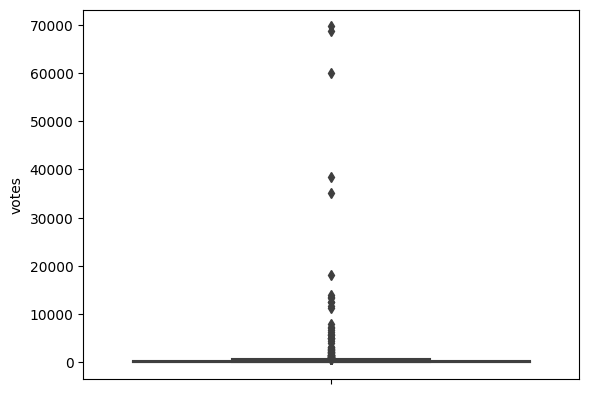

time: 260 ms


In [15]:
sns.boxplot( y=df['votes'] );

In [16]:
# sns.kdeplot(df['votes'], color="Red", shade = True)

time: 277 µs


In [17]:
print(np.max(df['votes']),np.mean(df['votes']),np.min(df['votes']))

69686 1232.9978260869566 1
time: 1.17 ms


In [18]:
df1=pd.DataFrame(df['date'].value_counts())
df1.columns=['counts']
df1.head(10)

counts
2019-02-05     116
2019-02-06      73
2019-02-07      59
2019-02-08      44
2019-02-09      26
2019-01-28      25
2019-02-10      21
2019-01-20      14
2019-02-12      14
2019-02-11      13

time: 9.28 ms


In [19]:
df1['index']=df1.index
fig = px.scatter(df1, x="index", y="counts",
	         size="counts",color="index",
              size_max=60)
fig.show()

time: 721 ms


In [20]:
list_day=['2019-02-05','2019-02-06','2019-02-07','2019-02-08','2019-02-09','2019-02-10','2019-02-11','2019-02-12','2019-02-13','2019-02-14']
df_1=df[df['date'].isin(list_day)]

time: 2.55 ms


In [21]:
df_1=df_1.groupby('date')['scores'].mean().reset_index(). \
sort_values('date',ascending=False).reset_index(drop=True)
df_1.head(30)

date     scores
0  2019-02-14  31.666667
1  2019-02-13  25.714286
2  2019-02-12  28.571429
3  2019-02-11  23.076923
4  2019-02-10  29.428571
5  2019-02-09  29.923077
6  2019-02-08  25.340909
7  2019-02-07  34.559322
8  2019-02-06  31.890411
9  2019-02-05  32.922414

time: 6.29 ms


In [22]:
import pyecharts.options as opts
from pyecharts.charts import Line
from pyecharts.commons.utils import JsCode


x_data = df_1['date'][::-1]
y_data = df_1['scores'][::-1]

background_color_js = (
    "new echarts.graphic.LinearGradient(0, 0, 0, 1, "
    "[{offset: 0, color: '#c86589'}, {offset: 1, color: '#06a7ff'}], false)"
)
area_color_js = (
    "new echarts.graphic.LinearGradient(0, 0, 0, 1, "
    "[{offset: 0, color: '#eb64fb'}, {offset: 1, color: '#3fbbff0d'}], false)"
)

c = (
    Line(init_opts=opts.InitOpts(bg_color=JsCode(background_color_js)))
    .add_xaxis(xaxis_data=x_data)
    .add_yaxis(
        series_name="",
        y_axis=y_data,
        is_smooth=True,
        is_symbol_show=True,
        symbol="circle",
        symbol_size=6,
        linestyle_opts=opts.LineStyleOpts(color="#fff"),
        label_opts=opts.LabelOpts(is_show=True, position="top", color="white"),
        itemstyle_opts=opts.ItemStyleOpts(
            color="red", border_color="#fff", border_width=3
        ),
        tooltip_opts=opts.TooltipOpts(is_show=False),
        areastyle_opts=opts.AreaStyleOpts(color=JsCode(area_color_js), opacity=1),
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="사용자 평점의 시간 추세",
            pos_bottom="5%",
            pos_left="center",
            title_textstyle_opts=opts.TextStyleOpts(color="#fff", font_size=16),
        ),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            boundary_gap=False,
            axislabel_opts=opts.LabelOpts(margin=30, color="#ffffff63"),
            axisline_opts=opts.AxisLineOpts(is_show=False),
            axistick_opts=opts.AxisTickOpts(
                is_show=True,
                length=25,
                linestyle_opts=opts.LineStyleOpts(color="#ffffff1f"),
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(color="#ffffff1f")
            ),
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value",
            position="right",
            axislabel_opts=opts.LabelOpts(margin=20, color="#ffffff63"),
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(width=2, color="#fff")
            ),
            axistick_opts=opts.AxisTickOpts(
                is_show=True,
                length=15,
                linestyle_opts=opts.LineStyleOpts(color="#ffffff1f"),
            ),
            splitline_opts=opts.SplitLineOpts(
                is_show=True, linestyle_opts=opts.LineStyleOpts(color="#ffffff1f")
            ),
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
)
c.render_notebook()

time: 7.13 ms


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 460 entries, 0 to 479
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   citys         460 non-null    object
 1   content       460 non-null    object
 2   evaluate      460 non-null    object
 3   nams          460 non-null    object
 4   scores        460 non-null    int64 
 5   votes         460 non-null    int64 
 6   days_of_year  460 non-null    int64 
 7   date          460 non-null    object
 8   week          460 non-null    int64 
 9   day           460 non-null    int64 
 10  hour          460 non-null    int64 
 11  province      460 non-null    object
dtypes: int64(6), object(6)
memory usage: 46.7+ KB
time: 5.76 ms


### 3、평론어통계

In [24]:
def seg_word(string):
    corpus = []  # 语料库
    stop = pd.read_csv(
        "./data/stoplist.txt", sep="bucunzai", encoding="utf-8", header=None
    )
    stopwords = [" "] + list(stop[0])  # 加上空格符号
    seg_list = jieba.cut(string, cut_all=False)  # 结巴分词
    corpu = []
    # 去除停用词
    for word in seg_list:
        if word not in stopwords:
            corpu.append(word)
    corpus.append(" ".join(corpu))
    return corpus

time: 615 µs


In [25]:
stwlist=[line.strip() for line in open('./data/stoplist.txt','r',encoding='utf-8').readlines()]

time: 2.54 ms


In [26]:
df['content'].apply(jieba.lcut).head()

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/27/wjv4y8_568q22ydq_8qyhdmc0000gn/T/jieba.cache
Loading model cost 0.756 seconds.
Prefix dict has been built successfully.


0    [一个, 悲伤, 的, 故事, ：, 太阳, 都, 要, 毁灭, ，, 地球, 都, 要, ...
1    [电影, 比, 预期, 要, 更, 恢弘, 磅礴, ，, 晨昏, 线, 过后, 的, 永夜,...
2    [还, 能, 更, 土, 更, 儿戏, 一点, 吗, ？, 毫无, 思考, 仅靠, 煽动, ...
3    [1, ., 终于, ，, 轮, 到, 我们, 仰望, 星空, 。, 2, ., 后, 启示...
4    [真为, 吴京, 的, 演技, 尴尬, ，, 总是, 摆, 出, 一副, 大义, 凌然, 的...
Name: content, dtype: object

time: 972 ms


In [27]:
content=''
for i in df['content']:
    content+=i

time: 668 µs


In [28]:
stwlist.append('\r\n')
dele = set(stwlist)
words = list(jieba.cut(content))
articleDict = {}
articleSet = set(words)-dele
for w in articleSet:
    if len(w)>1:
        articleDict[w] = words.count(w)

articlelist = sorted(articleDict.items(),key = lambda x:x[1], reverse = True)

for i in range(10):
    print(articlelist[i])

('中国', 248)
('地球', 220)
('电影', 219)
('科幻', 217)
('流浪', 111)
('特效', 109)
('科幻片', 83)
('人类', 81)
('科幻电影', 80)
('真的', 77)
time: 5.31 s


In [29]:
from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType

words = articlelist
c = (
    WordCloud()
    .add("", words, word_size_range=[20, 100], shape=SymbolType.DIAMOND)
    .set_global_opts(title_opts=opts.TitleOpts(title="전체 논평어운"))
)
c.render_notebook()

time: 212 ms


In [30]:
content_wonderful=''
for i in df[df['evaluate']=='추천']['content']:
    content_wonderful+=i
stwlist.append('\r\n')
dele = set(stwlist)
words = list(jieba.cut(content_wonderful))
articleDict = {}
articleSet = set(words)-dele
for w in articleSet:
    if len(w)>1:
        articleDict[w] = words.count(w)

articlelist = sorted(articleDict.items(),key = lambda x:x[1], reverse = True)

from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType

words = articlelist
c = (
    WordCloud()
    .add("", words, word_size_range=[20, 100], shape=SymbolType.DIAMOND)
    .set_global_opts(title_opts=opts.TitleOpts(title="추천 사운"))
)
c.render_notebook()

time: 15.8 ms


In [31]:
content_aw=''
for i in df[df['evaluate']=='나쁜 평론']['content']:
    content_aw+=i
stwlist.append('\r\n')
dele = set(stwlist)
words = list(jieba.cut(content_aw))
articleDict = {}
articleSet = set(words)-dele
for w in articleSet:
    if len(w)>1:
        articleDict[w] = words.count(w)

articlelist = sorted(articleDict.items(),key = lambda x:x[1], reverse = True)

from pyecharts import options as opts
from pyecharts.charts import WordCloud
from pyecharts.globals import SymbolType

words = articlelist
c = (
    WordCloud()
    .add("", words, word_size_range=[20, 100], shape=SymbolType.DIAMOND)
    .set_global_opts(title_opts=opts.TitleOpts(title="나쁜 평론 사운"))
)
c.render_notebook()

time: 7.66 ms


### 4、감정분석

In [32]:
df_1=df[df['scores']>0]#剔除空值
print('빈 값으로 채점된 샘플의 수는：',df.shape[0]-df_1.shape[0])
#判断30分的正负倾向
df[df['scores']==30].head(10)

빈 값으로 채점된 샘플의 수는： 14


citys  \
5                        上海   
47                       北京   
51                     陕西西安   
54  P'y?ngyang, North Korea   
65                       北京   
71                       -1   
74                       -1   
75                       上海   
83                       -1   
84                       北京   

                                              content evaluate        nams  \
5                      三星鼓励一下吧，四个字：太儿戏了。硬科幻和硬要科幻是两回事。       还行          艾晨   
47  1.从特效和技术上讲，这应该是迄今为止此类中国电影的巅峰了。磅礴恢宏，细节营造用心。2.故事...       还行  frozenmoon   
51  1. 煽情、尴尬与生硬并存\r\n2.主要是2001太空漫游（致敬AI杀人太空戏）和罗兰.艾...       还行         江寒园   
54  7分，当时看的时候，最大的感受就是，影片终于用一种好莱坞灾难片的模式，来处理这部电影，这使得...       还行       桃桃淘电影   
65  史诗感不是靠狂轰滥炸的煽情就可以做到的，这部电影的双线叙事做得太糙、太散、太自我陶醉了。最可...       还行          阿暖   
71  走出影厅的时候，我身后一位女生跟她的同伴说了三句话：“这部电影剧情很一般，网上打分高大概是因...       还行          咱说   
74                      这部电影只能证明我们的特效起步了，我们的科幻片还没有起步。       还行         小啊原   
75  2.5；首先是宏大设定题材的胜利，木星的壮阔斑斓与荒原废土视效展现的工业制作水准有惊喜，让人...       还行        欢乐分裂   
83  只能说前期宣传太强势导致期望过高，男一女一演技拖后腿，而且想说本人非常相当不喜欢绑架型宣传的...       还行         孟三哥   
84  “咔嚓一下震天响，来了战狼当球长。带领人类救地球，一场大火没咋地。”能有部特效还看得过去的硬...       还行         汪金卫   

    scores  votes  days_of_year        date  week  day  hour province  
5       30  18016            17  2019-01-28     5   28    21       上海  
47      30   3018            25  2019-02-05     6    5    16       北京  
51      30   2612            25  2019-02-05     6    5    14       陕西  
54      30   1228            27  2019-02-07     6    7    23  outside  
65      30   1442            18  2019-01-29     5   29    11       北京  
71      30    814            29  2019-02-09     6    9     9  outside  
74      30    904            25  2019-02-05     6    5     3  outside  
75      30    652            25  2019-02-05     6    5    17       上海  
83      30    716            25  2019-02-05     6    5     0  outside  
84      30    652            18  2019-01-29     5   29    16       北京

time: 18.3 ms


In [33]:
def pos(x):
    if x>20:
        return 1
    else:
        return 0
df_1['pos']=df_1['scores'].apply(pos)
y_pred=df_1['pos'].values
df_1.head()

citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour province  pos  
0      40  35161            25  2019-02-05     6    5     0       北京    1  
1      40  68629            24  2019-02-04     6    4    15       北京    1  
2      10  69686            17  2019-01-28     5   28    22       北京    0  
3      50  59980            18  2019-01-29     5   29    20       北京    1  
4      10  38488            25  2019-02-05     6    5     1  outside    0

time: 14.1 ms


In [34]:
def get_moods(x):
    return SnowNLP(x).sentiments
df_1['moods']=df_1['content'].apply(get_moods)
df_1.head()

citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour province  pos  \
0      40  35161            25  2019-02-05     6    5     0       北京    1   
1      40  68629            24  2019-02-04     6    4    15       北京    1   
2      10  69686            17  2019-01-28     5   28    22       北京    0   
3      50  59980            18  2019-01-29     5   29    20       北京    1   
4      10  38488            25  2019-02-05     6    5     1  outside    0   

      moods  
0  1.000000  
1  1.000000  
2  1.000000  
3  1.000000  
4  0.999994

time: 18.5 s


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

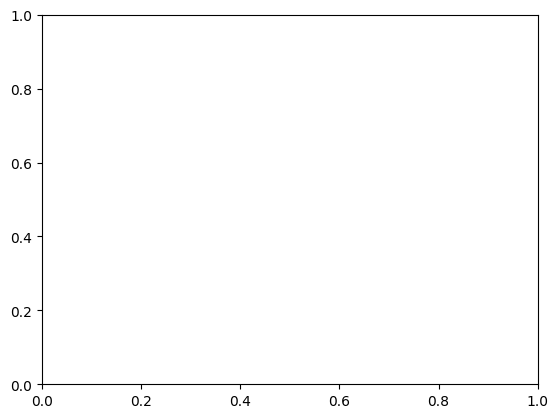

time: 2.04 s


In [35]:
sns.kdeplot (df_1['moods'], color="Red", shade = True)

In [37]:
def moods_pos(x):
    if x>0.5:
        return 1
    else:
        return 0
df_1['moods_pos']=df_1['moods'].apply(moods_pos)

time: 1.36 ms


In [38]:
print(precision_score(df_1['moods_pos'], y_pred,average='micro'))
pd.DataFrame(confusion_matrix(df_1['moods_pos'], y_pred))

0.7242152466367713


0    1
0   16   20
1  103  307

time: 18.5 ms


In [39]:
print(classification_report(df_1['moods_pos'], y_pred))

              precision    recall  f1-score   support

           0       0.13      0.44      0.21        36
           1       0.94      0.75      0.83       410

    accuracy                           0.72       446
   macro avg       0.54      0.60      0.52       446
weighted avg       0.87      0.72      0.78       446

time: 6.81 ms


In [40]:
print('SnowNlp 정확성：',np.sum(df_1['moods_pos'] == y_pred) / len(y_pred))

SnowNlp 정확성： 0.7242152466367713
time: 1.2 ms


In [41]:
import codecs
import re
from collections import defaultdict  # 导入collections用于创建空白词典

import jieba


def seg_word(sentence):
    seg_list = jieba.cut(sentence)
    seg_result = []
    for word in seg_list:
        seg_result.append(word)
        stopwords = set()
        stopword = codecs.open("./data/stoplist.txt", "r", encoding="utf-8")  # 加载停用词
    for word in stopword:
        stopwords.add(word.strip())
    stopword.close()
    return list(filter(lambda x: x not in stopwords, seg_result))


def sort_word(word_dict):
    sen_file = open(
        "./data/BosonNLP_sentiment_score.txt", "r+", encoding="utf-8"
    )  # 加载Boson情感词典
    sen_list = sen_file.readlines()
    sen_dict = defaultdict()  # 创建词典
    for s in sen_list:
        s = re.sub("\n", "", s)  # 去除每行最后的换行符
        if s:
            # 构建以key为情感词，value为对应分值的词典
            sen_dict[s.split(" ")[0]] = s.split(" ")[1]
    not_file = open("./data/否定词.txt", "r+", encoding="utf-8")  # 加载否定词词典
    not_list = not_file.readlines()
    for i in range(len(not_list)):
        not_list[i] = re.sub("\n", "", not_list[i])
    degree_file = open("./data/程度副词（中文）.txt", "r+", encoding="utf-8")  # 加载程度副词词典
    degree_list = degree_file.readlines()
    degree_dic = defaultdict()
    for d in degree_list:
        d = re.sub("\n", "", d)
        if d:
            degree_dic[d.split(" ")[0]] = d.split(" ")[1]
    sen_file.close()
    degree_file.close()
    not_file.close()
    sen_word = dict()
    not_word = dict()
    degree_word = dict()
    # 分类
    for word in word_dict.keys():
        if (
            word in sen_dict.keys()
            and word not in not_list
            and word not in degree_dic.keys()
        ):
            sen_word[word_dict[word]] = sen_dict[word]  # 情感词典中的包含分词结果的词
        elif word in not_list and word not in degree_dic.keys():
            not_word[word_dict[word]] = -1  # 程度副词词典中的包含分词结果的词
        elif word in degree_dic.keys():
            # 否定词典中的包含分词结果的词
            degree_word[word_dict[word]] = degree_dic[word]
    return sen_word, not_word, degree_word  # 返回分类结果


def list_to_dict(word_list):
    data = {}
    for x in range(0, len(word_list)):
        data[word_list[x]] = x
    return data


def socre_sentiment(sen_word, not_word, degree_word, seg_result):
    W = 1  # 初始化权重
    score = 0
    sentiment_index = -1  # 情感词下标初始化
    for i in range(0, len(seg_result)):
        if i in sen_word.keys():
            score += W * float(sen_word[i])
            sentiment_index += 1  # 下一个情感词
            for j in range(len(seg_result)):
                if j in not_word.keys():
                    score *= -1  # 否定词反转情感
                elif j in degree_word.keys():
                    score *= float(degree_word[j])  # 乘以程度副词
    return score


def setiment(sentence):
    # 对文本进行分词和去停用词，去除跟情感词无关的词语
    seg_list = seg_word(sentence)
    # 对分词结果进行分类，找出其中的情感词、程度副词和否定词
    sen_word, not_word, degree_word = sort_word(list_to_dict(seg_list))
    # 计算并汇总情感词的得分
    score = socre_sentiment(sen_word, not_word, degree_word, seg_list)
    # return seg_list, sen_word, not_word, degree_word, score
    return score

time: 6.96 ms


In [42]:
df_1['moods_dict']=df_1['content'].apply(setiment)
df_1.head()

citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour province  pos  \
0      40  35161            25  2019-02-05     6    5     0       北京    1   
1      40  68629            24  2019-02-04     6    4    15       北京    1   
2      10  69686            17  2019-01-28     5   28    22       北京    0   
3      50  59980            18  2019-01-29     5   29    20       北京    1   
4      10  38488            25  2019-02-05     6    5     1  outside    0   

      moods  moods_pos    moods_dict  
0  1.000000          1 -6.087825e-01  
1  1.000000          1  4.051344e+09  
2  1.000000          1  9.918786e-02  
3  1.000000          1  2.330640e+16  
4  0.999994          1  9.804465e-01

time: 1min 20s


In [43]:
def moods_dict_pos(x):
    if x>0:#大于0判为正向
        return 1
    else:
        return 0
df_1['moods_dict_pos']=df_1['moods_dict'].apply(moods_pos)
df_1.head()

citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour province  pos  \
0      40  35161            25  2019-02-05     6    5     0       北京    1   
1      40  68629            24  2019-02-04     6    4    15       北京    1   
2      10  69686            17  2019-01-28     5   28    22       北京    0   
3      50  59980            18  2019-01-29     5   29    20       北京    1   
4      10  38488            25  2019-02-05     6    5     1  outside    0   

      moods  moods_pos    moods_dict  moods_dict_pos  
0  1.000000          1 -6.087825e-01               0  
1  1.000000          1  4.051344e+09               1  
2  1.000000          1  9.918786e-02               0  
3  1.000000          1  2.330640e+16               1  
4  0.999994          1  9.804465e-01               1

time: 8.17 ms


In [44]:
pd.DataFrame(confusion_matrix(df_1['moods_dict_pos'], y_pred))

0    1
0  50   62
1  69  265

time: 6.94 ms


In [45]:
print(classification_report(df_1['moods_dict_pos'], y_pred))
print('moods_dict_정확성：',precision_score(df_1['moods_dict_pos'], y_pred,average='micro'))

              precision    recall  f1-score   support

           0       0.42      0.45      0.43       112
           1       0.81      0.79      0.80       334

    accuracy                           0.71       446
   macro avg       0.62      0.62      0.62       446
weighted avg       0.71      0.71      0.71       446

moods_dict_정확성： 0.7062780269058296
time: 6.09 ms


In [46]:
df_1[['moods_dict','moods','scores']].corr()

moods_dict     moods    scores
moods_dict    1.000000  0.018548 -0.049152
moods         0.018548  1.000000  0.106056
scores       -0.049152  0.106056  1.000000

time: 5.82 ms


In [47]:
from pyecharts.charts import Line
from pyecharts import options as opts


cate = [str(i) for i in df_1['nams'][100:150]]
data1 = df_1['moods'][100:150]
data2 = [(i-10)/40 for i in df_1['scores']][100:150]

line = (Line()
       .add_xaxis(cate)
       .add_yaxis('텍스트 감정 점수', data1, 
                  markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average")]))
       .add_yaxis('사용자 평점', data2, 
                  is_smooth=True, 
                  # markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(name="自定义标记点", 
                                                                        #      coord=[cate[2], data2[2]], value=data2[2])])
                                                                             )
      .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
       .set_global_opts(title_opts=opts.TitleOpts(title="평점과 텍스트 감정의 추세 비교", subtitle=""),datazoom_opts=[opts.DataZoomOpts()])
      )

line.render_notebook()

time: 6.85 ms


In [48]:
res = jieba.analyse.textrank(content, topK=100, withWeight=True, allowPOS=('ns', 'n', 'vn', 'v', 'nr', 'nrt', 'z', 'r', 'x'))
words=[]
weights=[]
for word, weight in res[:20]:
    words.append(word)
    weights.append(weight)
    print('%s %.4f'%(word, weight)) 

中国 1.0000
电影 0.8509
地球 0.8157
科幻 0.8156
没有 0.5070
流浪 0.3937
人类 0.3509
科幻电影 0.2820
人物 0.2670
科幻片 0.2638
煽情 0.2598
这部 0.2584
好莱坞 0.2361
国产 0.2354
我们 0.2287
故事 0.2287
希望 0.2282
这个 0.2227
什么 0.2171
这种 0.2151
time: 2.68 s


In [49]:
df1=pd.DataFrame()
df1['index']=range(20)
df1['words']=words[::-1]
df1['weights']=weights[::-1]
fig = px.scatter(df1, x="index", y="weights",
	         size="weights",color="words",
              size_max=60)
fig.show()

time: 79.1 ms


#### 5.2、LDA

In [50]:
# 创建停用词列表
stopwords = [line.strip() for line in open('./data/stoplist.txt',encoding='UTF-8').readlines()]

# 对句子进行中文分词
def seg_depart(sentence):
    # 对文档中的每一行进行中文分词
    print("正在分词")
    sentence_depart = jieba.cut(sentence.strip())
    # 追加停用词
    stopwords.append('\r\n')
    stopwords.append('°')
    stopwords.append("")
    stopwords.append("「")
    # 输出结果为outstr
    outstr = ''
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr

time: 2.17 ms


In [51]:
content_pos=''
content_neg=''
for i in df_1[df_1['pos']==1]['content']:
    content_pos+=i
for i in df_1[df_1['pos']==0]['content']:
    content_neg+=i
    
word_pos=seg_depart(content_pos).split(' ')
word_neg=seg_depart(content_neg).split(' ')

正在分词
正在分词
time: 2.03 s


In [52]:
# 建立词典
pos_dict = corpora.Dictionary([[i] for i in word_pos])  # 正面
neg_dict = corpora.Dictionary([[i] for i in word_neg])  # 负面

# 建立语料库
pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in word_pos]]  # 正面
neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in word_neg]]   # 负面

time: 105 ms


In [53]:
#主题数寻优
# 余弦相似度函数
def cos(vector1, vector2):
    dot_product = 0.0;  
    normA = 0.0;  
    normB = 0.0;  
    for a,b in zip(vector1, vector2): 
        dot_product += a*b  
        normA += a**2  
        normB += b**2  
    if normA == 0.0 or normB==0.0:  
        return(None)  
    else:  
        return(dot_product / ((normA*normB)**0.5))   

# 主题数寻优
def lda_k(x_corpus, x_dict):  
    
    # 初始化平均余弦相似度
    mean_similarity = []
    mean_similarity.append(1)
    
    # 循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        # LDA模型训练
        lda = models.LdaModel(x_corpus, num_topics = i, id2word = x_dict)
        for j in np.arange(i):
            term = lda.show_topics(num_words = 50)
            
        # 提取各主题词
        top_word = []
        for k in np.arange(i):
            top_word.append([''.join(re.findall('"(.*)"',i)) \
                             for i in term[k][1].split('+')])  # 列出所有词
           
        # 构造词频向量
        word = sum(top_word,[])  # 列出所有的词   
        unique_word = set(word)  # 去除重复的词
        
        # 构造主题词列表，行表示主题号，列表示各主题词
        mat = []
        for j in np.arange(i):
            top_w = top_word[j]
            mat.append(tuple([top_w.count(k) for k in unique_word]))  
            
        p = list(itertools.permutations(list(np.arange(i)),2))
        l = len(p)
        top_similarity = [0]
        for w in np.arange(l):
            vector1 = mat[p[w][0]]
            vector2 = mat[p[w][1]]
            top_similarity.append(cos(vector1, vector2))
            
        # 计算平均余弦相似度
        mean_similarity.append(sum(top_similarity)/l)
    return(mean_similarity)

time: 1.52 ms


In [54]:
# 计算主题平均余弦相似度
pos_k = lda_k(pos_corpus, pos_dict)
neg_k = lda_k(neg_corpus, neg_dict)
pos_k1=pd.DataFrame(pos_k,index=[np.arange(1,11)])
neg_k1=pd.DataFrame(neg_k,index=[np.arange(1,11)])

time: 31.5 s


Text(0.5, 0, 'Optimization of LDA Topics in Negative Comments')

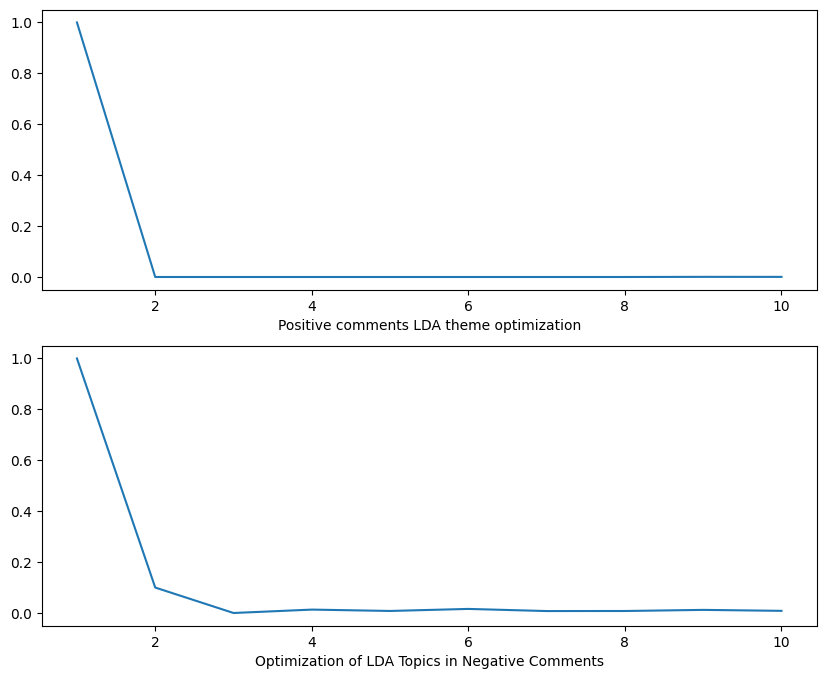

time: 198 ms


In [55]:
# 绘制主题平均余弦相似度图形
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(1,11),pos_k)
ax1.set_xlabel('Positive comments LDA theme optimization')

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(1,11),neg_k)
ax2.set_xlabel('Optimization of LDA Topics in Negative Comments')

In [56]:
# 评价主题分析结果
# LDA主题分析
pos_lda = models.LdaModel(pos_corpus, num_topics = 2, id2word = pos_dict) 
neg_lda = models.LdaModel(neg_corpus, num_topics = 3, id2word = neg_dict)

time: 5.39 s


In [57]:
print(pos_lda.print_topics(num_words = 10))
print(neg_lda.print_topics(num_words = 10))

[(0, '0.050*"" + 0.023*"中国" + 0.019*"科幻" + 0.010*"流浪" + 0.007*"中" + 0.007*"台词" + 0.006*"人类" + 0.006*"希望" + 0.006*"穿越" + 0.006*"故事"'), (1, '0.020*"电影" + 0.017*"地球" + 0.007*"科幻电影" + 0.007*"特效" + 0.005*"星际" + 0.005*"一部" + 0.005*"感觉" + 0.005*"这部" + 0.005*"刘" + 0.005*"拍"')]
[(0, '0.021*"特效" + 0.020*"中国" + 0.017*"剧情" + 0.012*"流浪" + 0.009*"救" + 0.009*"剪辑" + 0.008*"想" + 0.008*"原著" + 0.007*"价值观" + 0.007*"情节"'), (1, '0.102*"" + 0.014*"真的" + 0.013*"科幻" + 0.008*"煽情" + 0.007*"特别" + 0.007*"堆积" + 0.006*"人类" + 0.006*"演技" + 0.006*"科幻片" + 0.006*"集体"'), (2, '0.029*"地球" + 0.019*"电影" + 0.012*"拯救" + 0.012*"战狼" + 0.010*"尴尬" + 0.009*"感觉" + 0.008*"幻想" + 0.008*"设定" + 0.007*"元年" + 0.007*"一点"')]
time: 1.98 ms


In [58]:
from pyecharts.components import Table

table = Table()

headers = ["Topic Word Of Postive", "Topic1", "Topic2"]
rows = list(zip(['postive word']*10,[i[0] for i in pos_lda.show_topic(0,topn=10)],[i[0] for i in pos_lda.show_topic(1,topn=10)]))
table.add(headers, rows)

table.render_notebook()

time: 7.53 ms


In [59]:
from pyecharts.components import Table

table = Table()

headers = ["Topic Word Of Negtive", "Topic1", "Topic2",'Topic3']
rows = list(zip(['negtive word']*10,[i[0] for i in neg_lda.show_topic(0,topn=10)],[i[0] for i in neg_lda.show_topic(1,topn=10)],[i[0] for i in neg_lda.show_topic(2,topn=10)]))
table.add(headers, rows)

table.render_notebook()

time: 3.44 ms


### 6、텍스트 클러스터링 - 토픽 집계

In [60]:
sentences = df['content'].values.tolist()
for i in range(len(sentences)):
    sentences[i] = [str(x) for x in sentences[i]]

emb_size = 60 #提取60个特征
model = Word2Vec(sentences, size=emb_size, window=6, min_count=5, sg=0, hs=0, seed=1, iter=5)

emb_matrix = []
for seq in sentences:
    vec = []
    for w in seq:
        if w in model.wv.vocab:
            vec.append(model.wv[w])
    if len(vec) > 0:
        emb_matrix.append(np.mean(vec, axis=0))
    else:
        emb_matrix.append([0] * emb_size)
emb_matrix = np.array(emb_matrix)
df_2=pd.DataFrame()
for i in range(emb_size):
    df_2['content_emb_{}'.format(i)] = emb_matrix[:, i]
    
del emb_matrix,vec,sentences

time: 401 ms


In [61]:
df_2.head()

content_emb_0  content_emb_1  content_emb_2  content_emb_3  content_emb_4  \
0      -0.026340       0.481708       0.021812      -0.387450       0.049904   
1       0.050270       0.368354      -0.022750      -0.316316       0.003205   
2       0.049855       0.351517      -0.015942      -0.312285       0.013960   
3       0.038094       0.344112      -0.004825      -0.312040       0.028858   
4       0.056118       0.346456      -0.021215      -0.309040       0.001325   

   content_emb_5  content_emb_6  content_emb_7  content_emb_8  content_emb_9  \
0      -0.198013      -0.567649       0.071848       0.309885       0.323432   
1      -0.174958      -0.476982       0.147589       0.283997       0.323131   
2      -0.155701      -0.467458       0.136862       0.262556       0.304045   
3      -0.139940      -0.457251       0.114642       0.244816       0.286015   
4      -0.161023      -0.463889       0.138402       0.266484       0.303281   

   ...  content_emb_50  content_emb_51  content_emb_52  content_emb_53  \
0  ...        0.112387        0.324326       -0.413454        0.072233   
1  ...        0.163869        0.375660       -0.357809        0.076744   
2  ...        0.146098        0.356205       -0.354877        0.077548   
3  ...        0.127510        0.330615       -0.349617        0.075294   
4  ...        0.151601        0.356971       -0.351607        0.080252   

   content_emb_54  content_emb_55  content_emb_56  content_emb_57  \
0        0.017447       -0.145166       -0.447285        0.269262   
1        0.041865       -0.092087       -0.397755        0.246151   
2        0.036329       -0.104684       -0.391740        0.237085   
3        0.032196       -0.110033       -0.380452        0.230431   
4        0.034326       -0.107959       -0.392615        0.236343   

   content_emb_58  content_emb_59  
0       -0.466852       -0.455702  
1       -0.426302       -0.531111  
2       -0.420432       -0.522842  
3       -0.406459       -0.497519  
4       -0.420964       -0.525960  

[5 rows x 60 columns]

time: 14 ms


In [62]:
#对数据进行K近邻聚类
clf=KMeans(n_clusters=6,random_state=0)
clf.fit(df_2)

KMeans(n_clusters=6, random_state=0)

time: 302 ms


In [63]:
#定义获取话题平均评分的函数
def topic_rating(labels):
    topic=np.unique(labels)
    r=dict(zip(topic,np.zeros((len(topic),3)))) #初始化话题评分
    for i,j in enumerate(labels):
        r[j][0]+=df.iloc[i,:]['scores']
        r[j][1]+=1
    for i in r:
        r[i][2]=r[i][0]/r[i][1]
    r=pd.DataFrame(r,index=['total_sccore','counts','ave_scores']).T
    return r   

#获取聚类后各类的平均评价得分
r=topic_rating(clf.labels_).sort_values(by="ave_scores" , ascending=False)
r=r[r['counts']>10] #筛选评论数大于10的类别作为话题
r

total_sccore  counts  ave_scores
5        7854.0   241.0   32.589212
0        2218.0    69.0   32.144928
3        3385.0   108.0   31.342593
2        1049.0    34.0   30.852941

time: 88.4 ms


In [64]:
np.std(r['ave_scores'])

0.6763325278947727

time: 4.14 ms


In [65]:
df['label']=clf.labels_
id=r[r.counts>10].index
df.head()

citys                                            content evaluate     nams  \
0    北京            一个悲伤的故事：太阳都要毁灭，地球都要流浪了，我国的校服还是这么丑......       推荐     沙雕电影   
1    北京  电影比预期要更恢弘磅礴，晨昏线过后的永夜、火种计划、让地球流浪、木星推动地球…等等大小设定，...       推荐       影志   
2    北京  还能更土更儿戏一点吗？毫无思考仅靠煽动，毫无敬畏仅余妄想。好的科幻片应该首先承认人类的无知，...       很差  嘟嘟熊之父 ?   
3    北京  1.终于，轮到我们仰望星空。2.后启示录死亡废墟，赛博朋克地下城，以及烟波浩渺的末日想象，缔...       力荐      陆支羽   
4    -1  真为吴京的演技尴尬，总是摆出一副大义凌然的样子，好奇为什么刘的作品中总有这种傻逼般的圣母存在...       很差       侠侠   

   scores  votes  days_of_year        date  week  day  hour province  label  
0      40  35161            25  2019-02-05     6    5     0       北京      2  
1      40  68629            24  2019-02-04     6    4    15       北京      0  
2      10  69686            17  2019-01-28     5   28    22       北京      5  
3      50  59980            18  2019-01-29     5   29    20       北京      3  
4      10  38488            25  2019-02-05     6    5     1  outside      5

time: 14.9 ms


In [66]:
record={}
for i in id:
    content_k=''
    df_3=df[df['label']==i]
    for j in df_3['content']:
         content_k+=j
    res = jieba.analyse.textrank(content_k, topK=50, withWeight=True, allowPOS=('ns', 'n', 'vn', 'v', 'nr', 'nrt', 'z', 'r', 'x'))
    record[i]=[]
    for word, weight in res[:10]:
        record[i].append(word)
        # print('label %d :%s %.4f'%(i,word, weight)) 
record

{5: ['中国', '电影', '科幻', '没有', '地球', '科幻片', '人类', '这部', '科幻电影', '人物'],
 0: ['地球', '流浪', '中国', '科幻', '电影', '人类', '科幻电影', '没有', '宇宙', '看到'],
 3: ['中国', '科幻', '电影', '地球', '没有', '牺牲', '煽情', '问题', '人类', '什么'],
 2: ['电影', '中国', '感觉', '地球', '剧情', '逻辑', '科幻', '太空', '堆积', '台词']}

time: 2.99 s
